In [1]:
!pip install transformers
!pip install catboost
!pip install datasets
!pip install emoji
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8

In [2]:
import os, sys
from torch.utils import data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import evaluate
import re, string
import emoji
import nltk
import math
import tensorflow as tf
import torch
from torch.nn.functional import softmax
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification, BertTokenizerFast, TFBertModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline, BertModel

from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

import re, string

from tqdm import tqdm
from collections import defaultdict

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data clean

In [3]:
#Clean emojis from text
def strip_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [6]:
# read data

df_train = pd.read_csv("Corona_NLP_train.csv", 
                       encoding='latin-1')
df_test = pd.read_csv("Corona_NLP_test.csv", 
                      encoding='latin-1')

df_train = df_train[['OriginalTweet', 'Sentiment']]
df_test = df_test[['OriginalTweet', 'Sentiment']]

# clean data

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(strip_emoji)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(strip_all_entities)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(clean_hashtags)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(filter_chars)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(remove_mult_spaces)

df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(strip_emoji)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(strip_all_entities)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(clean_hashtags)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(filter_chars)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(remove_mult_spaces)

### Machine learning models

In [10]:
# Preprocess the data
df_train['Sentiment'] = df_train['Sentiment'].replace(['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], [0, 1, 2, 3, 4])

X = df_train['OriginalTweet'].values
y = df_train['Sentiment'].values

# Create a CountVectorizer representation of the data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
X = X.astype(np.float64)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# All classification models from scikit-learn
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    # ('SVM', SVC(probability=True, random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Naive Bayes', MultinomialNB()),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(eval_metric='mlogloss', random_state=42, use_label_encoder=False)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=False)),
    ('AdaBoost', AdaBoostClassifier(random_state=42))
]

# Evaluate each model
metrics = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo')

    metrics[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1, 'AUC': auc}
    print(f'{name} - Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Logistic Regression - Accuracy: 0.6251
              precision    recall  f1-score   support

           0       0.66      0.58      0.62      1056
           1       0.57      0.55      0.56      2006
           2       0.65      0.74      0.69      1553
           3       0.59      0.62      0.61      2287
           4       0.72      0.65      0.68      1330

    accuracy                           0.63      8232
   macro avg       0.64      0.63      0.63      8232
weighted avg       0.63      0.63      0.62      8232

K-Nearest Neighbors - Accuracy: 0.2704
              precision    recall  f1-score   support

           0       0.44      0.12      0.19      1056
           1       0.33      0.18      0.23      2006
           2       0.23      0.88      0.36      1553
           3       0.40      0.14      0.21      2287
           4       0.74      0.04      0.08      1330

    accuracy                           0.27      8232
   macro avg       0.43      0.27      0.21      8232

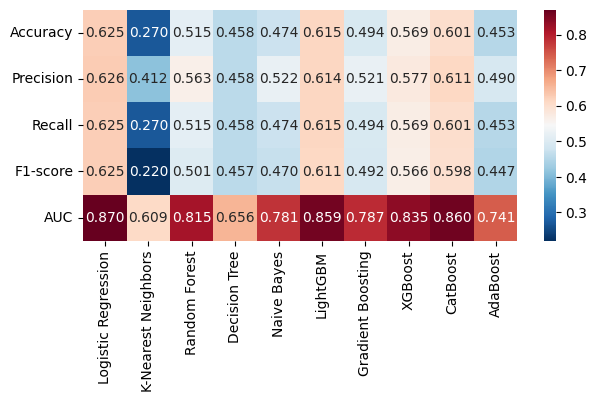

In [ ]:
metrics_df = pd.DataFrame(metrics)
plt.figure(figsize = (7, 3))
sns.heatmap(metrics_df, annot=True, fmt=".3f", cmap='RdBu_r')
plt.savefig("model_compare_hm.pdf", bbox_inches = 'tight')

<ipython-input-52-320e142155b0>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(models))


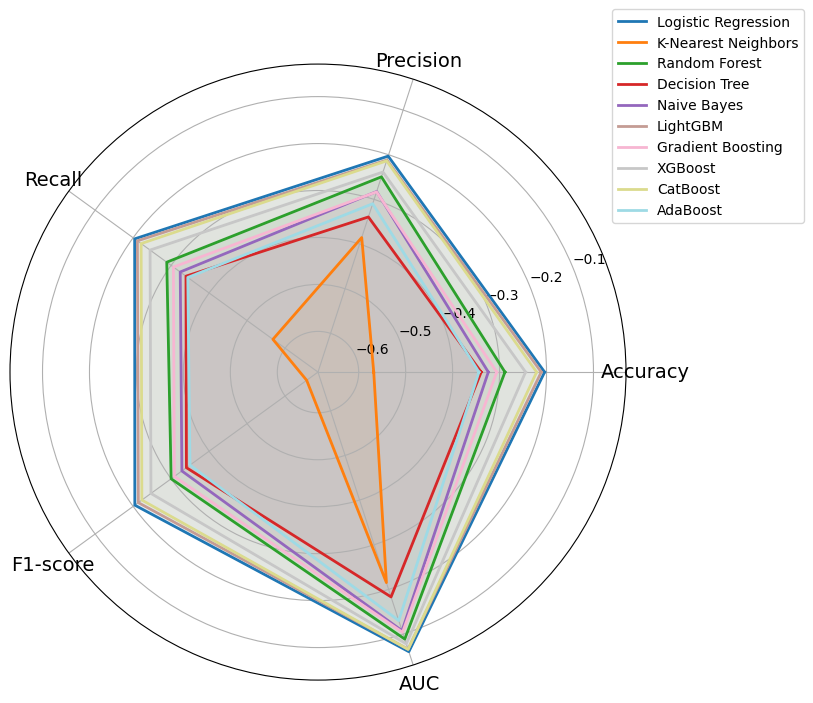

In [ ]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score', "AUC"]
num_vars = len(labels)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Ensure the plot is a closed shape

# Set the font size for the thetagrid labels
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=14)

def plot_radar(name, values, color, ax):
    log_values = [math.log10(val + 1e-6) for val in values]  # Apply log transformation
    log_values += log_values[:1]  # Ensure the plot is a closed shape
    ax.plot(angles, log_values, color=color, linewidth=2, label=name)
    ax.fill(angles, log_values, color=color, alpha=0.1)

colors = plt.cm.get_cmap('tab20', len(models))

for idx, (name, metric_values) in enumerate(metrics.items()):
    plot_radar(name, list(metric_values.values()), colors(idx), ax)

# Set the font size for the legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.savefig("model_compare.pdf", bbox_inches = 'tight')

### fine-turning logistic regression

In [ ]:
# Create different parameter grids for each solver
# lr_params_lbfgs = {
#     'solver': ['lbfgs'],
#     'C': [0.1, 1, 10],
#     'penalty': ['l2'],
#     'max_iter': [100, 500, 1000]
# }

# lr_params_liblinear = {
#     'solver': ['liblinear'],
#     'C': [0.1, 1, 10],
#     'penalty': ['l1', 'l2'],
#     'max_iter': [100, 500, 1000]
# }

lr_params_saga = {
    'solver': ['saga'],
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000]
}

# Combine parameter grids
lr_params = lr_params_saga.copy()
# lr_params.update(lr_params_liblinear)
# lr_params.update(lr_params_saga)

# Create a parameter grid
param_grid = ParameterGrid(lr_params)

# Train and evaluate the model for each combination of hyperparameters
results = []
for params in param_grid:
    lr = LogisticRegression(**params, random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({'params': params, 'f1_score': f1})

# Find the best model
best_result = max(results, key=lambda x: x['f1_score'])
print('Best LR Params:', best_result['params'])
print('Best LR F1 Score:', best_result['f1_score'])

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('hyperparameters_and_f1_scores_lr.csv', index=False)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

Best LR Params: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best LR F1 Score: 0.6758187048996063


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Logistic Regression tuning
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [100, 500, 1000]
}

lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=2, scoring='f1_weighted', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print('Best LR Params:', lr_grid.best_params_)
print('Best LR Score:', lr_grid.best_score_)

# Convert the results to a DataFrame
cv_results = pd.DataFrame(lr_grid.cv_results_)

# Filter the relevant columns
cv_results = cv_results[[
    'params', 'mean_test_score', 'std_test_score', 'rank_test_score'
]]

# Save the results to a CSV file
cv_results.to_csv('hyperparameters_and_f1_scores_lr.csv', index=False)

In [ ]:
cv_results.to_csv('/content/drive/MyDrive/hyperparameters_and_f1_scores_lr.csv', index=False)

In [ ]:
params_f1 = pd.read_csv("/content/drive/MyDrive/hyperparameters_and_f1_scores_lr.csv")
cols = list(eval(params_f1.iloc[0, 0]).keys())
cols.extend(['mean_test_score', 'std_test_score', 'rank_test_score'])
params_f1_df = pd.DataFrame(columns = cols); params_f1_df

In [ ]:
for i in params_f1.index:
  params = params_f1.loc[i, 'params']
  params = eval(params)
  params_f1_df.loc[i, 'C'] = params['C']
  params_f1_df.loc[i, 'solver'] = params['solver']
  params_f1_df.loc[i, 'penalty'] = params['penalty']
  params_f1_df.loc[i, 'max_iter'] = params['max_iter']
  params_f1_df.loc[i, 'mean_test_score'] = params_f1.loc[i, 'mean_test_score']
  params_f1_df.loc[i, 'std_test_score'] = params_f1.loc[i, 'std_test_score']
  params_f1_df.loc[i, 'rank_test_score'] = params_f1.loc[i, 'rank_test_score']

In [ ]:
params_f1_df

In [ ]:
params_f1_df = params_f1_df.sort_values(by = ['mean_test_score'], ascending = False)

In [ ]:
hip.Experiment.from_dataframe(params_f1_df.drop(columns = ['std_test_score', 'rank_test_score'])).display()

### confusion matrix for logistic regression

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)

### deep learning models

In [ ]:
df_train['Sentiment']=df_train['Sentiment'].replace({'Extremely Negative':0,'Negative':1, 'Neutral':2, 'Positive':3,'Extremely Positive':4})
df_train['Sentiment']=df_train['Sentiment'].astype(int)
df_train['tweet_length'] = df_train['OriginalTweet'].apply(lambda t: len(t.split()))

df_test['Sentiment']=df_test['Sentiment'].replace({'Extremely Negative':0,'Negative':1, 'Neutral':2, 'Positive':3,'Extremely Positive':4})
df_test['Sentiment']=df_test['Sentiment'].astype(int)
df_test['tweet_length'] = df_test['OriginalTweet'].apply(lambda t: len(t.split()))

In [ ]:
df_train = df_train.rename(columns = {'OriginalTweet': 'text', 'Sentiment': 'label'})
df_test = df_test.rename(columns = {'OriginalTweet': 'text', 'Sentiment': 'label'})

In [ ]:
hg_train_data = Dataset.from_pandas(df_train)
hg_test_data = Dataset.from_pandas(df_test)

In [ ]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["text"], 
                     max_length=64, 
                     truncation=True, 
                     padding="max_length")

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)

Map:   0%|          | 0/41157 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

In [ ]:
# Take a look at the data
print(dataset_train[1])
print(dataset_test[1])

{'text': 'advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order', 'label': 3, 'tweet_length': 38, 'input_ids': [101, 5566, 2037, 1106, 1240, 18832, 1266, 1106, 3670, 2179, 2849, 2561, 3232, 2190, 1114, 2179, 2849, 1104, 18832, 2126, 11440, 17382, 176, 1643, 1383, 1146, 3294, 6001, 5756, 1191, 185, 13159, 12373, 5508, 1104, 2366, 1143, 3680, 1133, 1136, 1166, 1546, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results/",          
    logging_dir='./results/logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=10,              
    per_device_train_batch_size=64,  
    per_device_eval_batch_size=2,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1": f1}

In [ ]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.786900,0.775068,0.699658
2,0.667000,0.694545,0.735902
3,0.573600,0.693064,0.743332
4,0.510500,0.630918,0.778645
5,0.464900,0.643815,0.767375
6,0.427100,0.614877,0.791237
7,0.395200,0.641912,0.785920
8,0.375800,0.640457,0.789137
9,0.362400,0.639964,0.788115
10,0.350900,0.638069,0.795941


TrainOutput(global_step=6440, training_loss=0.49143129194745366, metrics={'train_runtime': 4464.0561, 'train_samples_per_second': 92.196, 'train_steps_per_second': 1.443, 'total_flos': 1.353644173673856e+16, 'train_loss': 0.49143129194745366, 'epoch': 10.0})

In [ ]:
data = {'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'Training Loss': [0.786900, 0.667000, 0.573600, 0.510500, 0.464900, 0.427100, 0.395200, 0.375800, 0.362400, 0.350900],
        'Validation Loss': [0.775068, 0.694545, 0.693064, 0.630918, 0.643815, 0.614877, 0.641912, 0.640457, 0.639964, 0.638069],
        'F1': [0.699658, 0.735902, 0.743332, 0.778645, 0.767375, 0.791237, 0.785920, 0.789137, 0.788115, 0.795941]}

history = pd.DataFrame(data)

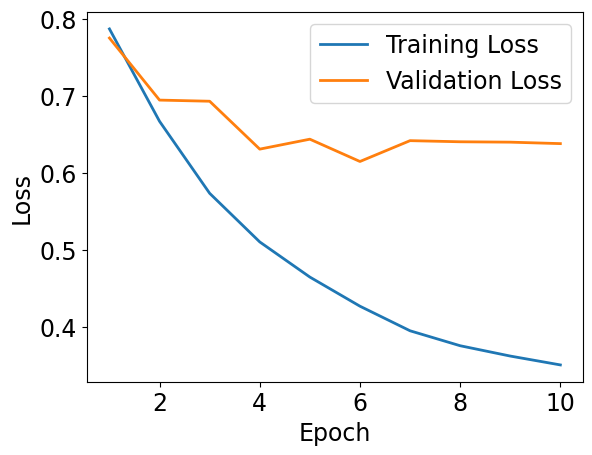

In [ ]:
sns.lineplot(x='Epoch', y='Training Loss', data=history, label='Training Loss', linewidth=2)
sns.lineplot(x='Epoch', y='Validation Loss', data=history, label='Validation Loss', linewidth=2)
plt.legend(fontsize=17)
plt.ylabel('Loss', fontsize=17)
plt.xlabel('Epoch', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig("train_val_loss.pdf", bbox_inches = 'tight')
plt.show()

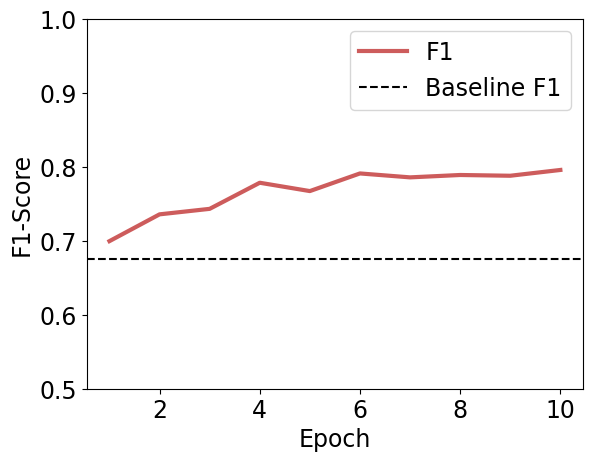

In [ ]:
sns.lineplot(x='Epoch', y='F1', data=history, label='F1', color='indianred', linewidth=3)
plt.axhline(y=0.6758187048996063, color='black', linestyle='--', label='Baseline F1', )
plt.legend(fontsize=17)
plt.ylim(0.5, 1)
plt.ylabel('F1-Score', fontsize=17)
plt.xlabel('Epoch', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig("f1-score.pdf", bbox_inches = 'tight')
plt.show()

In [ ]:
# Save tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/sentiment_transfer_learning_transformer')

# Save model
trainer.save_model('/content/drive/MyDrive/sentiment_transfer_learning_transformer')

### Load trained model

In [ ]:
# Predictions
y_test_predict = trainer.predict(dataset_test)

# Predicted logits
y_test_logits = y_test_predict.predictions

# First 5 predicted probabilities
y_test_logits[:5]

array([[-0.30382597,  4.1541114 , -0.0887372 , -0.9088177 , -3.5356212 ],
       [-3.105016  , -1.15824   , -0.95282996,  3.8888469 ,  1.543471  ],
       [-0.8023734 , -2.2154984 , -1.9461931 ,  0.46155503,  4.886314  ],
       [ 3.1373508 ,  3.317336  , -1.265191  , -1.81259   , -2.9056067 ],
       [-3.0460572 , -0.15546057,  4.1528125 ,  0.12386722, -2.6281962 ]],
      dtype=float32)

In [ ]:
# Predicted probabilities
y_test_probabilities = tf.nn.softmax(y_test_logits)

# First 5 predicted logits
y_test_probabilities[:5]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1.1218959e-02, 9.6830040e-01, 1.3911196e-02, 6.1264359e-03,
        4.4299790e-04],
       [8.2579086e-04, 5.7855453e-03, 7.1048141e-03, 9.0004909e-01,
        8.6234763e-02],
       [3.3266053e-03, 8.0963428e-04, 1.0598555e-03, 1.1773848e-02,
        9.8303002e-01],
       [4.5067286e-01, 5.3954542e-01, 5.5190171e-03, 3.1924886e-03,
        1.0701342e-03],
       [7.2346022e-04, 1.3025217e-02, 9.6793026e-01, 1.7222464e-02,
        1.0987259e-03]], dtype=float32)>

In [ ]:
# Predicted labels
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)
y_test_pred_labels[:5]

array([1, 3, 4, 1, 2])

In [ ]:
# Actual labels
y_test_actual_labels = y_test_predict.label_ids
y_test_actual_labels[:5]

array([0, 3, 4, 1, 2])

In [ ]:
trainer.evaluate(dataset_test)

{'eval_loss': 0.6148774027824402,
 'eval_f1': 0.7912372825687516,
 'eval_runtime': 33.1657,
 'eval_samples_per_second': 114.516,
 'eval_steps_per_second': 57.258,
 'epoch': 10.0}

In [ ]:
# f1
metric_f1 = evaluate.load("f1")
f1 = f1_score(y_test_actual_labels, y_test_pred_labels, average='weighted')

# recall
metric_recall = evaluate.load("recall")
metric_recall.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average = 'weighted')

# roc_auc
from sklearn.metrics import roc_auc_score
roc_auc_ovo = roc_auc_score(y_test_actual_labels, y_test_probabilities, multi_class="ovo", average="weighted")

# accuracy
metric_accuracy = evaluate.load("accuracy")
metric_accuracy.compute(predictions=y_test_pred_labels, references=y_test_actual_labels)

# precision
metric_precision = evaluate.load("precision")
metric_precision.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average = 'weighted')

{'f1': 0.7912372825687516}

In [ ]:
accuracy = accuracy_score(y_test_actual_labels, y_test_pred_labels)
precision = precision_score(y_test_actual_labels, y_test_pred_labels, average='weighted')
recall = recall_score(y_test_actual_labels, y_test_pred_labels, average='weighted')
f1 = f1_score(y_test_actual_labels, y_test_pred_labels, average='weighted')
auc = roc_auc_score(y_test_actual_labels, y_test_probabilities, average='weighted', multi_class='ovo')

In [ ]:
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1", f1)
print("auc", auc)

accuracy 0.7904160084254871
precision 0.7950125586266394
recall 0.7904160084254871
f1 0.7912372825687516
auc 0.9492556089335535


### Model compare

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

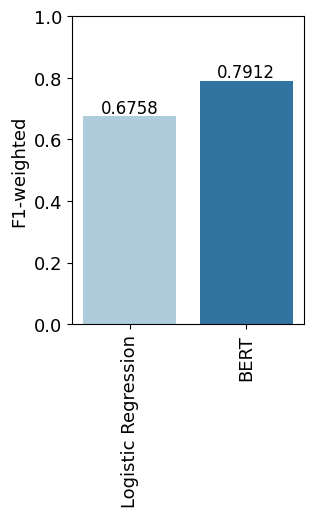

In [ ]:
lr_vs_bert = pd.DataFrame({"Model": ["Logistic Regression", "BERT"],
                           "F1-weighted": [0.6758187048996063, 0.7912372825687516]})

# plot
plt.figure(figsize = (3, 4))
colors = sns.color_palette("Paired")
ax = sns.barplot(x="Model", y="F1-weighted", data = lr_vs_bert, palette=colors)

plt.ylabel('F1-weighted', fontsize = 13)
plt.xticks(fontsize = 13, rotation=90)
plt.yticks(fontsize = 13)
plt.xlabel('')
plt.ylim(0, 1)

# Add values
for i, row in lr_vs_bert.iterrows():
    ax.text(i, row["F1-weighted"] + 0.01, f'{row["F1-weighted"]:.4f}', fontsize=12, horizontalalignment='center')

plt.savefig("best_model_compare.pdf", bbox_inches = 'tight')
plt.show()

### confusion matrix for bert

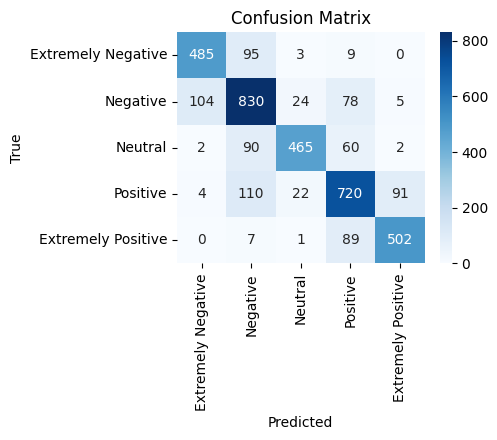

In [ ]:
# Define the class labels
labels = ['Extremely Negative','Negative', 'Neutral', 'Positive','Extremely Positive']

# Plot the confusion matrix
plot_confusion_matrix(y_test_actual_labels, y_test_pred_labels, labels)
plt.savefig("confusion_matrix_bert.pdf", bbox_inches = 'tight')

### Model evaluation

In [ ]:
# BERT

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/sentiment_transfer_learning_transformer")

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/sentiment_transfer_learning_transformer/')

# Logistic regression
model = LogisticRegression(C = 1, max_iter=1000, penalty='l1', solver='saga', random_state=42)
model.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

In [ ]:
# time consuming -- skip
# cali_model = CalibratedClassifierCV(model)
# cali_model.fit(X_train, y_train)

In [ ]:
# Preprocess the data
df_test['Sentiment'] = df_test['Sentiment'].replace(['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], [0, 1, 2, 3, 4])

X = df_test['OriginalTweet'].values
y = df_test['Sentiment'].values

# Create a CountVectorizer representation of the data
X_test_lr = vectorizer.transform(X)
X_test_lr = X_test_lr.astype(np.float64)

In [ ]:
def analyze_sent(input_sentence):
    input_tokens = tokenizer(input_sentence, return_tensors="pt")

    # Move the input tensor to the same device as the model (either 'cpu' or 'cuda')
    input_tokens = {key: val.to(loaded_model.device) for key, val in input_tokens.items()}

    # Pass the tokenized input through the model
    with torch.no_grad():
        model_output = loaded_model(**input_tokens)

    # Extract logits from the model output
    logits = model_output.logits

    # Convert logits to probabilities using the softmax function
    probabilities = softmax(logits, dim=1)

    # Get the predicted class (the index with the highest probability)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities

In [ ]:
pred_bert = np.array([analyze_sent(i)[1][0].tolist() for i in X])
pred_lr = model.predict_proba(X_test_lr)
# skip
# pred_lr_cali = cali_model.predict_proba(X_test_lr)

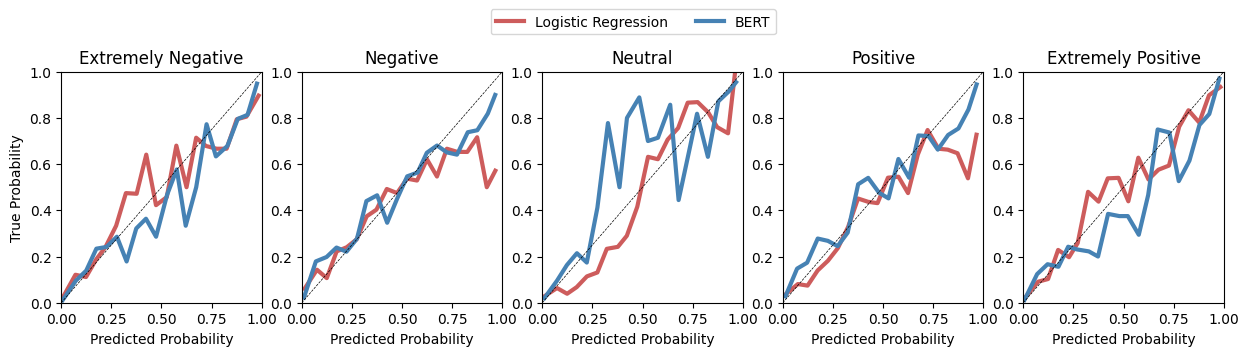

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (15, 3))

c = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

for i in range(5):
    y_test = [1 if c == i else 0 for c in y]

    prob_true, prob_pred = calibration_curve(y_test, pred_lr[:, i], n_bins=20)
    ax[i].plot(prob_pred, prob_true, '-', color='indianred', lw=3, label = 'Logistic Regression')

    # prob_true, prob_pred = calibration_curve(y_test, pred_lr_cali[:, i], n_bins=20)
    # ax[i].plot(prob_pred, prob_true, '-', color='green', lw=3, label = 'Cali Logistic Regression')

    prob_true, prob_pred = calibration_curve(y_test, pred_bert[:, i], n_bins=20)
    ax[i].plot(prob_pred, prob_true, '-', color='steelblue', lw=3, label='BERT')

    ax[i].set_title(c[i])
    ax[i].set_xlabel("Predicted Probability")
    ax[i].set_ylabel("True Probability")
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 1)
    ax[i].plot([0.0, 1.0], [0.0, 1.0], '--k', lw=0.5)

    if i > 0:
        ax[i].set_ylabel("")

ax[0].legend(bbox_to_anchor=(3.6, 1.3), ncol = 2)
plt.savefig("calibrate.pdf", bbox_inches = 'tight')

### Look at cases which model doesn't works well

In [7]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/sentiment_transfer_learning_transformer")

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/sentiment_transfer_learning_transformer/')

In [8]:
def analyze_sent(input_sentence):
    input_tokens = tokenizer(input_sentence, return_tensors="pt")

    # Move the input tensor to the same device as the model (either 'cpu' or 'cuda')
    input_tokens = {key: val.to(loaded_model.device) for key, val in input_tokens.items()}

    # Pass the tokenized input through the model
    with torch.no_grad():
        model_output = loaded_model(**input_tokens)

    # Extract logits from the model output
    logits = model_output.logits

    # Convert logits to probabilities using the softmax function
    probabilities = softmax(logits, dim=1)

    # Get the predicted class (the index with the highest probability)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities

In [12]:
df_train['Sentiment']=df_train['Sentiment'].replace({'Extremely Negative':0,'Negative':1, 'Neutral':2, 'Positive':3,'Extremely Positive':4})
df_train['Sentiment']=df_train['Sentiment'].astype(int)
df_train['tweet_length'] = df_train['OriginalTweet'].apply(lambda t: len(t.split()))

df_test['Sentiment']=df_test['Sentiment'].replace({'Extremely Negative':0,'Negative':1, 'Neutral':2, 'Positive':3,'Extremely Positive':4})
df_test['Sentiment']=df_test['Sentiment'].astype(int)
df_test['tweet_length'] = df_test['OriginalTweet'].apply(lambda t: len(t.split()))

In [14]:
df_test.head()

,OriginalTweet,Sentiment,tweet_length
0,trending new yorkers encounter empty supermark...,0,21
1,when i couldnt find hand sanitizer at fred mey...,3,29
2,find out how you can protect yourself and love...,4,12
3,panic buying hits newyork city as anxious shop...,1,35
4,toiletpaper dunnypaper coronavirus coronavirus...,2,25


In [15]:
df_test['PredSent'] = df_test['OriginalTweet'].apply(lambda x: analyze_sent(x)[0])

In [17]:
df_test['diff'] = np.abs(df_test['Sentiment'] - df_test['PredSent'])

In [19]:
df_test = df_test.sort_values(by = 'diff', ascending = False)

In [20]:
df_test

,OriginalTweet,Sentiment,tweet_length,PredSent,diff
1355,i dont know why i was scared to go to the groc...,3,27,0,3
2181,common dont ruin my weekend keep prices down f...,3,17,0,3
501,i dont rly understand the stock market nor do ...,3,44,0,3
2032,we may have no food because we have no space t...,0,38,3,3
3050,normally i am on the opposite end of a bhakt b...,4,43,1,3
...,...,...,...,...,...
1435,pls be mindful amp kind to each otherremember ...,3,44,3,0
1436,in light of president mcrobbies covid19 messag...,2,38,2,0
1437,covid19uk has got us all worried if your out s...,4,42,4,0
1438,lets see how long covid19 survives dublin rent...,2,9,2,0


In [21]:
df_test.loc[1355, 'OriginalTweet']

'i dont know why i was scared to go to the grocery store today the only viruses i was exposed to were peoples badass kids covid19 coronapocalypse'

In [22]:
df_test.loc[2181, 'OriginalTweet']

'common dont ruin my weekend keep prices down for a month plz oilprice coronavirus covid19 coronaviruspandemic coronaoutbreak'

In [26]:
df_test.loc[501, 'OriginalTweet']

'i dont rly understand the stock market nor do i ideologically believe it matters at this point i understand itll affect other things but what matters rn is peoples healththeir ability to access healthcare food safety etc but i think this is bad coronavirus'

In [27]:
df_test.loc[2032, 'OriginalTweet']

'we may have no food because we have no space to hoard tinned tuna but we have 48 extra long rolls of recycled toilet paper downunder loorollshortage covid19 tbh we were not buying out of panic its our'

In [28]:
df_test.loc[3050, 'OriginalTweet']

'normally i am on the opposite end of a bhakt but in the case of covid19 i am strongly joining a growing chorus of people who demand that china mend its ways every few years a new pathogen their barbaric food habits are'

### How/Why the COVID sentiment could be positive

In [33]:
df_test.sort_values(by = ['Sentiment'], ascending = False)

,OriginalTweet,Sentiment,tweet_length,PredSent,diff
3797,i and members are committed to the safety of o...,4,30,4,0
582,thank goodness i was able to get to the grocer...,4,13,4,0
614,globalwebindex did some research on covid19 th...,4,36,4,0
597,at a grocery store standing around with a few ...,4,19,4,0
646,you know whats great to do when youre in the g...,4,47,4,0
...,...,...,...,...,...
2668,more worried about people then coronavirus thi...,0,10,0,0
1692,i dont know which one is more likely to kill m...,0,19,0,0
2514,rumors and misinformation is dangerous creatin...,0,41,0,0
2992,what the hell is wrong with people the panic t...,0,46,0,0


In [34]:
df_test.loc[3797, 'OriginalTweet']

'i and members are committed to the safety of our employees and our endusers we are monitoring covid19 rest assured that tissue manufacturers are continuing to produce and ship products'

In [35]:
df_test.loc[582, 'OriginalTweet']

'thank goodness i was able to get to the grocery store this morningcovid19'

In [36]:
df_test.loc[614, 'OriginalTweet']

'globalwebindex did some research on covid19 this was one of the more interesting stats theres strong consumer support for digital health appointments 60 would consider using them if available and only about 15 rule them out'